In [1]:
import sys
sys.path.append("../src")
import numpy as np
import pandas as pd
from opt_summary import OptSummary
from sd_summary import SDSummary
from no_del_summary import NoDeletionSummary
import time
from utils import *
import stopit
plt.rc('axes', axisbelow=True)

@stopit.threading_timeoutable(default=(np.nan, np.nan))
def exec_summary(s, values, f, k, beta, jit=False):
    start_time = time.time()
    if s == 'NO DEL':
        test = NoDeletionSummary(values, f, beta)
        err = test.summarize()
    elif s == 'DS':
        values, f = outlier_removal(values, f, del_percentage)
        test = NoDeletionSummary(values, f, beta)
        err = test.summarize()
    elif s == 'SD CON':
        test = SDSummary(values, f, beta, k, method='con')
        err = test.summarize(k)
    elif s == 'SD ARB':
        test = SDSummary(values, f, beta, k, method='arb')
        err = test.summarize(k)
    elif s == 'CON': 
        test = OptSummary(values, f, beta, k, method='con')
        if jit == True:
            test.jit == True
        err = test.summarize(k)
    elif s == 'ARB':
        test = OptSummary(values, f, beta, k, method='arb')
        err = test.summarize(k)
        
    elapsed = (time.time() - start_time)
    return err, elapsed

### In the cell below you can specify the parameters for the experiments.
- timeout: In seconds. Choose how long a summary is allowed to run before stoping its execution.(Use a smaller timeout for the experiments to run faster. However SD ARB and ARB algorithms will probably yield no result if it is too low as they are the slowest ones)
- dataset: Uncomment one of the three available datasets.
- frac: float in [0.0, 0.1]. Percentage of the dataset to be uniformely sampled. The experiments will be run on that sample. The default value is 0.10 a smaller value will make the experiments run faster due to the smaller size. However the results might not be that reliable. Higher values will lead to slower execution times.


In [2]:
timeout = 120

#dataset = 'temperature'
dataset = 'capital'
#dataset = 'hours'
if dataset == 'hours':
    file = '../data/hours_per_week.csv'
elif dataset == 'temperature':
    file = '../data/india_temp.csv'
elif dataset == 'capital':
    file = '../data/capital_gain.csv'

frac = 0.1
    
file = '../data/cars_year_produced.csv'
data_name = file.split('/')[2].rstrip('.csv')
print(f'Dataset: {data_name}')

Dataset: cars_year_produced


### Loading the dataset

In [3]:

df = pd.read_csv(file, header=None)
df = df.sample(frac = frac, random_state=0)
df = df.loc[:,0].value_counts()
df = df.sort_index()
values = df.index.values
f = df.values

### Comparing the error ratio and the execution time of the algorithms on a uniform sample of the dataset.
### Number of buckets = 10, Number of deletions = a percentage ρ = 2% of the size of the dataset.

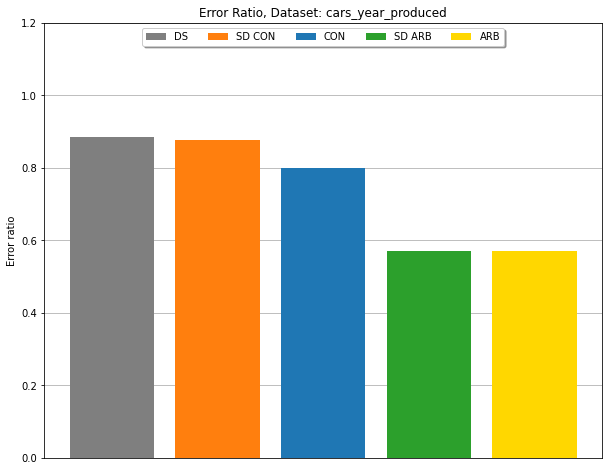

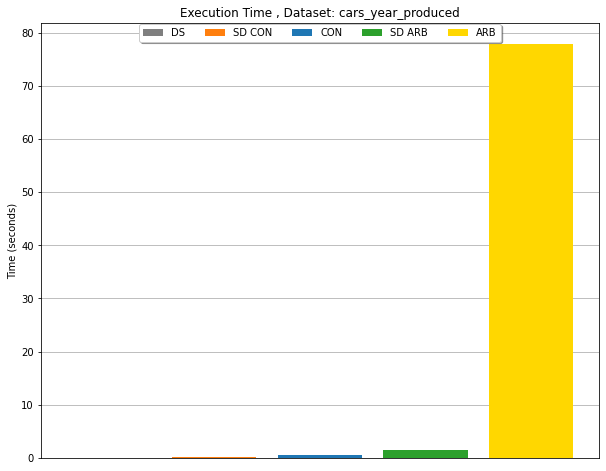

In [4]:
beta = 10
del_percentage = 0.02
k = int(np.sum(f) * del_percentage)


err, elapsed = exec_summary('NO DEL', values, f, k, beta, timeout=timeout)
no_del_err = err
no_del_time = elapsed

err, elapsed = exec_summary('DS', values, f, k, beta, timeout=timeout)
ds_err = err
ds_time = elapsed

err, elapsed = exec_summary('SD ARB', values, f, k, beta, timeout=timeout)
sd_arb_err = err
sd_arb_time = elapsed

err, elapsed = exec_summary('SD CON', values, f, k, beta, timeout=timeout)
sd_con_err = err
sd_con_time = elapsed

err, elapsed = exec_summary('ARB', values, f, k, beta, timeout=timeout)
arb_err = err
arb_time = elapsed

err, elapsed = exec_summary('CON', values, f, k, beta, timeout=timeout)
con_err = err
con_time = elapsed

ep = 1e-9
res_err = np.array([ds_err, sd_con_err, con_err, sd_arb_err, arb_err]) / (no_del_err + ep)
res_err = np.nan_to_num(res_err)

color = ['tab:gray', 'tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['DS', 'SD CON', 'CON', 'SD ARB', 'ARB']
plt.figure(figsize=(10,8))
plt.title(f'Error Ratio, Dataset: {data_name}')
plt.ylabel('Error ratio')
plt.ylim([0, 1.2])
plt.grid(axis='y', zorder=0)
for i, re in enumerate(res_err):
    plt.bar(i, re, color = color[i], label = labels[i])
plt.xticks([])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fancybox=True, shadow=True)
plt.show()

res_time = np.array([ds_time, sd_con_time, con_time, sd_arb_time, arb_time])
res_time = np.nan_to_num(res_time)

color = ['tab:gray', 'tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['DS', 'SD CON', 'CON', 'SD ARB', 'ARB']
plt.figure(figsize=(10,8))
plt.title(f'Execution Time , Dataset: {data_name}')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', zorder=0)
for i, re in enumerate(res_time):
    plt.bar(i, re, color = color[i], label = labels[i])
plt.xticks([])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=len(labels), fancybox=True, shadow=True)
plt.show()

### Comparing the error ratio and the execution time of the algorithms on a uniform sample of the dataset.
### We keep the number of buckets constant (10) while varying the number of deletion from 1% to 5% of the size of the dataset.

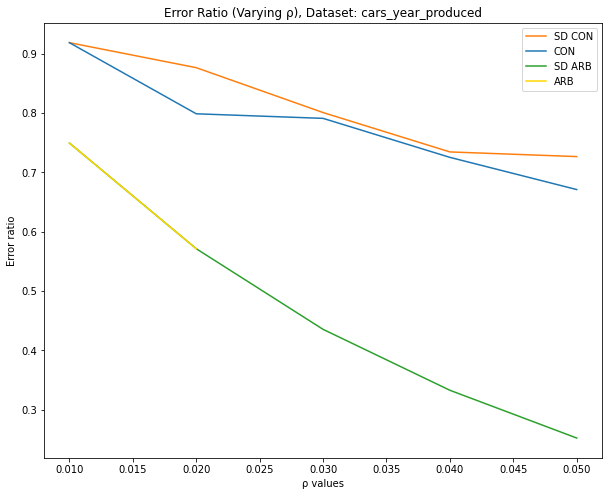

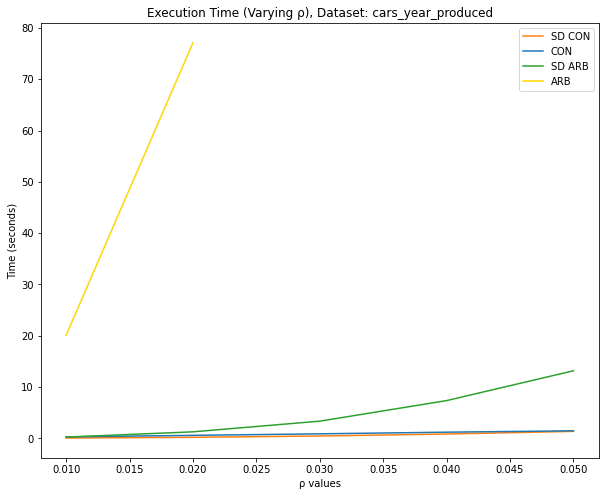

In [5]:

del_percentages = list(np.linspace(0.01, 0.05, 5))
no_del_errors = []
ds_errors = []
sd_con_errors = []
sd_arb_errors = []
opt_con_errors = []
opt_arb_errors = []
no_del_times = []
ds_times = []
sd_con_times = []
sd_arb_times = []
opt_con_times = []
opt_arb_times = []
beta = 10

for del_percentage in del_percentages:
    k = int(np.sum(f) * del_percentage)
    
    err, elapsed = exec_summary('NO DEL', values, f, k, beta, timeout=timeout)
    no_del = err + 1e-9

    err, elapsed = exec_summary('SD ARB', values, f, k, beta, timeout=timeout)
    sd_arb_errors.append(err/no_del)
    sd_arb_times.append(elapsed)

    err, elapsed = exec_summary('SD CON', values, f, k, beta, timeout=timeout)
    sd_con_errors.append(err/no_del)
    sd_con_times.append(elapsed)
    
    err, elapsed = exec_summary('ARB', values, f, k, beta, timeout=timeout)
    opt_arb_errors.append(err/no_del)
    opt_arb_times.append(elapsed)

    err, elapsed = exec_summary('CON', values, f, k, beta, timeout=timeout)
    opt_con_errors.append(err/no_del)
    opt_con_times.append(elapsed)
    
color = ['tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['SD CON', 'CON', 'SD ARB', 'ARB']
res_errors = [sd_con_errors, opt_con_errors, sd_arb_errors, opt_arb_errors]
plt.figure(figsize=(10,8))
plt.title(f'Error Ratio (Varying ρ), Dataset: {data_name}')
plt.ylabel('Error ratio')
plt.xlabel('ρ values')
for i, t in enumerate(res_errors):
    plt.plot(del_percentages, t, color=color[i], label=labels[i])
plt.legend()
plt.show()

color = ['tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['SD CON', 'CON', 'SD ARB', 'ARB']
res_times = [sd_con_times, opt_con_times, sd_arb_times, opt_arb_times]
plt.figure(figsize=(10,8))
plt.title(f'Execution Time (Varying ρ), Dataset: {data_name}')
plt.ylabel('Time (seconds)')
plt.xlabel('ρ values')
for i, t in enumerate(res_times):
    plt.plot(del_percentages, t, color=color[i], label=labels[i])
plt.legend()
plt.show()



### Comparing the error ratio and the execution time of the algorithms on a uniform sample of the dataset.
### We keep the number of deletions constant (2% of the size of the data) while varying the number of buckets from 1 to 30.

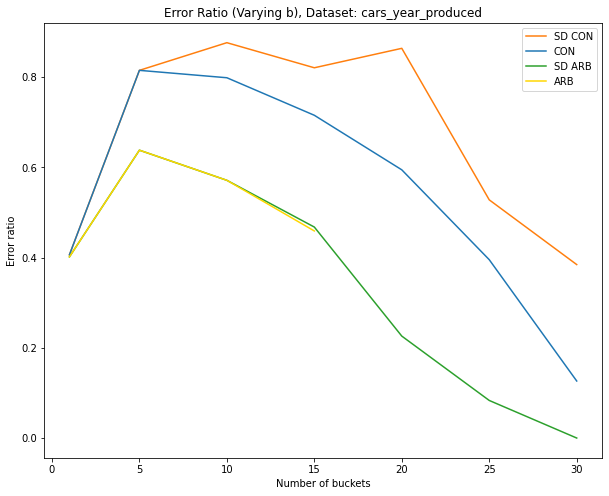

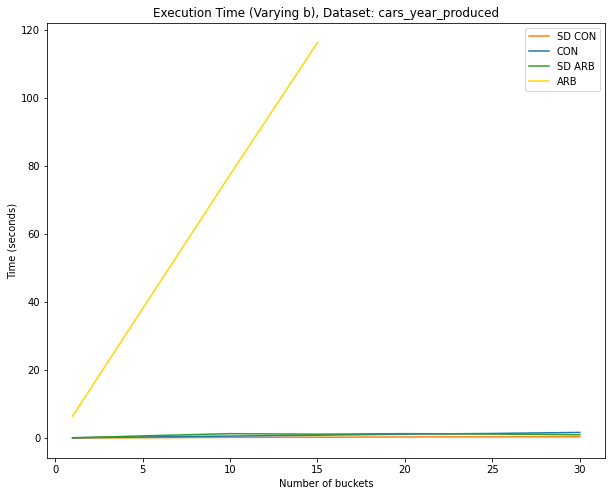

In [6]:

no_del_errors = []
ds_errors = []
sd_con_errors = []
sd_arb_errors = []
opt_con_errors = []
opt_arb_errors = []
no_del_times = []
ds_times = []
sd_con_times = []
sd_arb_times = []
opt_con_times = []
opt_arb_times = []
betas = [1, 5, 10, 15, 20, 25, 30]

del_percentage = 0.02

for beta in betas:
    k = int(np.sum(f) * del_percentage)
    
    err, elapsed = exec_summary('NO DEL', values, f, k, beta, timeout=timeout)
    no_del = err + 1e-9

    err, elapsed = exec_summary('SD ARB', values, f, k, beta, timeout=timeout)
    sd_arb_errors.append(err/no_del)
    sd_arb_times.append(elapsed)

    err, elapsed = exec_summary('SD CON', values, f, k, beta, timeout=timeout)
    sd_con_errors.append(err/no_del)
    sd_con_times.append(elapsed)
    
    err, elapsed = exec_summary('ARB', values, f, k, beta, timeout=timeout)
    opt_arb_errors.append(err/no_del)
    opt_arb_times.append(elapsed)

    err, elapsed = exec_summary('CON', values, f, k, beta, timeout=timeout)
    opt_con_errors.append(err/no_del)
    opt_con_times.append(elapsed)
    
color = ['tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['SD CON', 'CON', 'SD ARB', 'ARB']
res_errors = [sd_con_errors, opt_con_errors, sd_arb_errors, opt_arb_errors]
plt.figure(figsize=(10,8))
plt.title(f'Error Ratio (Varying b), Dataset: {data_name}')
plt.ylabel('Error ratio')
plt.xlabel('Number of buckets')
for i, t in enumerate(res_errors):
    plt.plot(betas, t, color=color[i], label=labels[i])
plt.legend()
plt.show()

color = ['tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['SD CON', 'CON', 'SD ARB', 'ARB']
res_times = [sd_con_times, opt_con_times, sd_arb_times, opt_arb_times]
plt.figure(figsize=(10,8))
plt.title(f'Execution Time (Varying b), Dataset: {data_name}')
plt.ylabel('Time (seconds)')
plt.xlabel('Number of buckets')
for i, t in enumerate(res_times):
    plt.plot(betas, t, color=color[i], label=labels[i])
plt.legend()
plt.show()


